In [1]:
from catboost import Pool, CatBoostRegressor
#from category_encoders import OrdinalEncoder, OneHotEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

In [2]:
def parse_csv(path, col_name, start_index=0):
    df = pd.read_csv(path, decimal=',')
    list_of_df = []
    for i in range(len(df)):
        new_df = df.iloc[i,:].to_frame(name=col_name).reset_index()
        if col_name == 'flammability':
            new_df = df.iloc[i,:].to_frame(name="flammability").reset_index()
            new_df['region'] = new_df.iloc[1,1]
            new_df['OSM_ID'] = new_df.iloc[0,1]
            new_df = new_df.iloc[3:,:]
            list_of_df.append(new_df)
        else:
            new_df['OSM_ID'] = new_df.iloc[0,1]
            new_df = new_df.iloc[1:,:]
            list_of_df.append(new_df)
    
    df = pd.concat(list_of_df).reset_index()
    df = df.rename(columns={"index": "year"})
    df = df.drop(['level_0'], axis=1)
    return df

list_of_df = [parse_csv('data/flam_dynamics.csv', 'flammability', 1),
              parse_csv('data/NDVI_dynamics.csv', 'NDVI'),
              parse_csv('data/precip_dynamics.csv', 'precipitation'),
              parse_csv('data/stock_dynamics.csv','livestock'),
              parse_csv('data/t_max_dynamics.csv','t_max')]
list_of_df[0]

,year,flammability,region,OSM_ID
0,2001,28.62,Ахтубинский район,-1850408
1,2002,15.94,Ахтубинский район,-1850408
2,2003,0.66,Ахтубинский район,-1850408
3,2004,2.52,Ахтубинский район,-1850408
4,2005,11.46,Ахтубинский район,-1850408
...,...,...,...,...
1155,2016,0.0,Уральск Г.А.,-3767383
1156,2017,1.25,Уральск Г.А.,-3767383
1157,2018,4.8,Уральск Г.А.,-3767383
1158,2019,0.0,Уральск Г.А.,-3767383


In [3]:
df_subjects = pd.read_csv('data/flam_dynamics.csv', decimal=',')
df_subjects['Region'].unique()

array(['AST', 'ATY', 'KL', 'SAR', 'VGG', 'ZKO'], dtype=object)

In [4]:
df_subjects.head()

,OSM_ID,NAME,Region,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,-1850408,Ахтубинский район,AST,28.62,15.94,0.66,2.52,11.46,16.28,3.77,...,2.11,4.00,0.00,16.59,1.42,2.39,20.90,0.74,2.68,4.33
1,-1863175,Володарский район,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-1853865,городской округ Астрахань,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-1853856,Енотаевский район,AST,10.63,7.04,2.07,3.16,2.48,13.61,1.58,...,2.95,1.01,0.00,1.54,0.00,0.14,0.18,0.00,0.12,0.00
4,-1957534,Икрянинский район,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,-1957535,Камызякский район,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,-1863174,Красноярский район,AST,4.99,0.35,1.64,7.71,0.00,25.11,9.21,...,31.06,2.46,0.00,22.91,7.87,5.92,12.50,1.76,8.09,17.46
7,-1853857,Лиманский район,AST,0.08,13.33,0.03,4.88,3.35,19.64,6.71,...,13.22,0.00,0.00,4.02,6.65,0.00,1.07,0.06,0.00,0.00
8,-1853860,Наримановский район,AST,0.08,0.32,0.53,1.28,0.03,1.29,0.71,...,3.80,1.97,0.00,1.45,0.50,0.00,0.00,0.12,0.26,0.05
9,-1863176,Приволжский район,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


![title](img/UFO1_pol.jpg)

![title](img/kaz_pol.png)

In [5]:
df_region = pd.read_csv('data/Municipals.csv', encoding="windows-1251", delimiter=';', decimal=',')
df_region = df_region.drop(['Region','NAME', 'Area_ha'], axis=1)

In [6]:
import functools as ft
df = ft.reduce(lambda left, right: pd.merge(left, right, on=['OSM_ID','year']), list_of_df)

In [7]:
df = df.merge(df_region, on=['OSM_ID'])
df.head()

,year,flammability,region,OSM_ID,NDVI,precipitation,livestock,t_max,N,E
0,2001,28.62,Ахтубинский район,-1850408,3443.553826,305.300003,NaN,22.864286,48.288975,46.400784
1,2002,15.94,Ахтубинский район,-1850408,3283.658314,327.975006,NaN,22.464286,48.288975,46.400784
2,2003,0.66,Ахтубинский район,-1850408,2986.687553,318.075005,NaN,20.989285,48.288975,46.400784
3,2004,2.52,Ахтубинский район,-1850408,3269.350491,319.725006,NaN,22.935715,48.288975,46.400784
4,2005,11.46,Ахтубинский район,-1850408,3305.540993,312.275009,NaN,22.800001,48.288975,46.400784


![title](img/ndvi.png)
t_max - динамика максимальных температур за год  
precipitation - динамика кол-ва осадков  
livestock - динамика поголовья скота  
NDVI - динамика нормализованного относительного индекса растительности

In [8]:
df = df.fillna(-9999)
df['flammability'] = np.log1p(df['flammability'])

In [9]:
df['previous_precipitation'] = df['precipitation'].shift(+1)
df.loc[df['year'] == '2001', 'previous_precipitation'] = np.nan
df['previous_precipitation'] = df.groupby(['region']).previous_precipitation.transform(lambda x: x.fillna(x.mean()))

df['previous_NDVI'] = df['NDVI'].shift(+1)
df.loc[df['year'] == '2001', 'previous_NDVI'] = np.nan
df['previous_NDVI'] = df.groupby(['region']).previous_NDVI.transform(lambda x: x.fillna(x.mean()))

Почему мы используем смещенные показали? Т.к. все показатели считаются на конец года, логично использовать смещенные данные, из практических целей это означает, что нам интересны условия предыдущего.

In [10]:
df = df.drop(['OSM_ID', 'year', 'region','precipitation', 'NDVI'], axis=1)
df.corr()

,flammability,livestock,t_max,N,E,previous_precipitation,previous_NDVI
flammability,1.000000,-0.071312,-0.160536,0.273249,0.231180,0.164865,-0.062828
livestock,-0.071312,1.000000,0.257455,0.048927,0.254161,-0.231002,-0.155804
t_max,-0.160536,0.257455,1.000000,-0.723279,0.176638,-0.675664,-0.330992
N,0.273249,0.048927,-0.723279,1.000000,0.180268,0.539406,0.147333
E,0.231180,0.254161,0.176638,0.180268,1.000000,-0.431731,-0.356354
previous_precipitation,0.164865,-0.231002,-0.675664,0.539406,-0.431731,1.000000,0.519401
previous_NDVI,-0.062828,-0.155804,-0.330992,0.147333,-0.356354,0.519401,1.000000


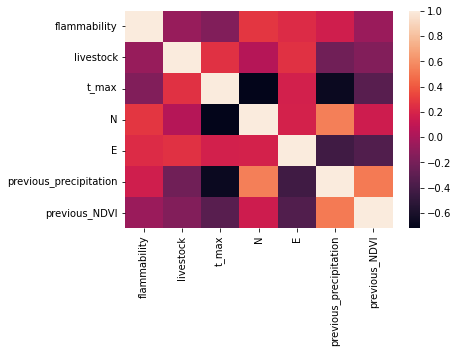

In [11]:
uniform_data = np.random.rand(20, 15)
ax = sns.heatmap(df.corr())

In [12]:
from sklearn.compose import ColumnTransformer

col_names = ['livestock', 't_max', 'previous_precipitation','N','E', 'previous_NDVI']
X = df[col_names]
cv = 10
scalers = (RobustScaler(), StandardScaler(), MinMaxScaler())

regressors = (
    RidgeCV(cv=cv, alphas=[0.0001, 0.001,0.01, 0.1, 1]), 
    LassoCV(cv=cv, alphas=[0.0001, 0.001,0.01, 0.1, 1], n_alphas=[100, 200, 300, 400]), 
    ElasticNetCV(cv=cv, alphas=[0.0001, 0.001,0.01, 0.1, 1, 10], n_alphas=[100, 200, 300, 400])
)

for scaler in scalers:
    for regressor in regressors:
        ct = ColumnTransformer([('scaler', scaler, ['livestock', 't_max', 
                                                    'previous_precipitation', 'previous_NDVI'])], remainder='passthrough')
        X_scaled = ct.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['flammability'], test_size=0.20, random_state=42)               
        
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        
        print('R2: ' + str(regressor.score(X_test, y_test)))
        print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
        print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
        print('Scaler: ' + scaler.__class__.__name__)
        print('Regressor\'s type:' + regressor.__class__.__name__)
        print('Best Alpha: ' + str(regressor.alpha_))
        print()
#         for col, coef in zip(df.columns, regressor.coef_):
#             print(col, coef)
        print('==' * 20)

R2: 0.11115355471066513
RMSE: 0.928833066164837
MAE: 0.7665524122275454
Scaler: RobustScaler
Regressor's type:RidgeCV
Best Alpha: 1.0

R2: 0.11094984042572453
RMSE: 0.9289394994664127
MAE: 0.7665629902569601
Scaler: RobustScaler
Regressor's type:LassoCV
Best Alpha: 0.0001

R2: 0.1113354494540787
RMSE: 0.9287380224722195
MAE: 0.7666244451850682
Scaler: RobustScaler
Regressor's type:ElasticNetCV
Best Alpha: 0.001

R2: 0.11100302164528086
RMSE: 0.9289117153904807
MAE: 0.7665685276019829
Scaler: StandardScaler
Regressor's type:RidgeCV
Best Alpha: 1.0

R2: 0.11091970020712982
RMSE: 0.9289552455983828
MAE: 0.766571346702964
Scaler: StandardScaler
Regressor's type:LassoCV
Best Alpha: 0.0001

R2: 0.1111168369961093
RMSE: 0.9288522507356766
MAE: 0.7666737980765922
Scaler: StandardScaler
Regressor's type:ElasticNetCV
Best Alpha: 0.001

R2: 0.113646428048785
RMSE: 0.9275296413856486
MAE: 0.7669044401627307
Scaler: MinMaxScaler
Regressor's type:RidgeCV
Best Alpha: 1.0

R2: 0.11108133507607998
RMSE

In [13]:
#Test Default CatBoost
print("Testing default Catboost")

scalers = (RobustScaler(), StandardScaler(), MinMaxScaler())
for scaler in scalers:
    
    ct = ColumnTransformer([('scaler', scaler, ['livestock', 't_max', 
                                                'previous_precipitation', 'previous_NDVI'])], remainder='passthrough')
    
    X_scaled = ct.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        df['flammability'], 
                                                        test_size=0.20, random_state=42)  
    model = CatBoostRegressor(logging_level='Silent')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    
    print('R2: ' + str(r2))
    print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
    print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
    print('Scaler: ' + scaler.__class__.__name__)
    #print(model.get_all_params())
    print('==' * 20)

Testing default Catboost
R2: 0.5644968565732795
RMSE: 0.9288356797489472
MAE: 0.7665922578794843
Scaler: RobustScaler
R2: 0.5644763173730916
RMSE: 0.9288356797489472
MAE: 0.7665922578794843
Scaler: StandardScaler
R2: 0.5642605110234277
RMSE: 0.9288356797489472
MAE: 0.7665922578794843
Scaler: MinMaxScaler


In [14]:
scaler = MinMaxScaler()
ct = ColumnTransformer([('scaler', scaler, ['livestock', 't_max', 
                                                'previous_precipitation', 'previous_NDVI'])], remainder='passthrough')
X_scaled = ct.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    df['flammability'], 
                                                    test_size=0.20, random_state=42)
model = CatBoostRegressor(logging_level='Silent')

grid = { 
        'learning_rate': [0.01, 0.03, 0.04, 0.1, 0.5],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7],
        'iterations': [250, 500, 1000]
       }

grid_search = model.grid_search(grid, X=X_train, y=y_train, plot=True, verbose=False)
#grid.fit(X_train, y_train)

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('R2: ' + str(r2))
print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
print('Scaler: ' + scaler.__class__.__name__)
print('Best params: ' + str(grid_search['params']))
print('==' * 20)
for x, y in zip(df.drop(['flammability'], axis=1), model.get_feature_importance()):
    print(x, y)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2: 0.5755047424648927
RMSE: 0.9288356797489472
MAE: 0.7665922578794843
Scaler: MinMaxScaler
Best params: {'depth': 8, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.04}
livestock 18.91099324674765
t_max 11.986564855314612
N 13.899634934020877
E 13.20465569130269
previous_precipitation 19.543007612968236
previous_NDVI 22.45514365964593


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        df['flammability'], 
                                                        test_size=0.20, random_state=42)

print(type(X_test))
param_grid = {
    'C': [1, 5, 100, 200, 1000],
    'epsilon': [0.01, 0.1, 0.05, 0.0003, 1, 0.2, 5, 10],
    'gamma': [0.001, 0.1, 1, 5, 10, 100]
}
grid_search = GridSearchCV(estimator = SVR(), param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 0)
regr = make_pipeline(RobustScaler(), grid_search)


regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))
print(regr[1].best_params_)

<class 'numpy.ndarray'>
0.4360795962044819
{'C': 1, 'epsilon': 0.2, 'gamma': 1}


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        df['flammability'], 
                                                        test_size=0.20, random_state=43)
knn = KNeighborsRegressor()
k_range = list(range(1, 50))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, verbose=1)

# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_estimator_)
grid.score(X_test, y_test)

Fitting 10 folds for each of 49 candidates, totalling 490 fits
KNeighborsRegressor(n_neighbors=6)


0.4178189850702526

Что можно сделать ещё?

1. Поискать ещё признаки.
1. Выяснить для каких районов/регионов мы хорошо предсказываем горимость.
2. Добавить карт.